In [3]:
cd drive/MyDrive/profile_labs/optimization/

/content/drive/MyDrive/profile_labs/optimization


In [7]:
import numpy as np
from scipy import linalg as la
from scipy.sparse import spdiags
from cvxopt import matrix, solvers
from scipy.linalg import lu_factor, lu_solve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import cvxpy as cp

Helper functions

In [5]:
def laplacian(n):
    """Construct the discrete Dirichlet energy matrix H for an n x n grid."""
    data = -1*np.ones((5, n**2))
    data[2,:] = 4
    data[1, n-1::n] = 0
    data[3, ::n] = 0
    diags = np.array([-n, -1, 0, 1, n])
    return spdiags(data, diags, n**2, n**2).toarray()

def startingPoint(G, c, A, b, guess):
    """
    Obtain an appropriate initial point for solving the QP
    .5 x^T Gx + x^T c s.t. Ax >= b.
    Parameters:
        G -- symmetric positive semidefinite matrix shape (n,n)
        c -- array of length n
        A -- constraint matrix shape (m,n)
        b -- array of length m
        guess -- a tuple of arrays (x, y, mu) of lengths n, m, and m, resp.
    Returns:
        a tuple of arrays (x0, y0, l0) of lengths n, m, and m, resp.
    """
    m,n = A.shape
    x0, y0, l0 = guess

    # Initialize linear system
    N = np.zeros((n+m+m, n+m+m))
    N[:n,:n] = G
    N[:n, n+m:] = -A.T
    N[n:n+m, :n] = A
    N[n:n+m, n:n+m] = -np.eye(m)
    N[n+m:, n:n+m] = np.diag(l0)
    N[n+m:, n+m:] = np.diag(y0)
    rhs = np.empty(n+m+m)
    rhs[:n] = -(G.dot(x0) - A.T.dot(l0)+c)
    rhs[n:n+m] = -(A.dot(x0) - y0 - b)
    rhs[n+m:] = -(y0*l0)

    sol = la.solve(N, rhs)
    dx = sol[:n]
    dy = sol[n:n+m]
    dl = sol[n+m:]

    y0 = np.maximum(1, np.abs(y0 + dy))
    l0 = np.maximum(1, np.abs(l0+dl))

    return x0, y0, l0

def qInteriorPoint(Q, c, A, b, guess, niter=20, tol=1e-16, verbose=False):
    """Solve the Quadratic program min .5 x^T Q x +  c^T x, Ax >= b
    using an Interior Point method.

    Parameters:
        Q ((n,n) ndarray): Positive semidefinite objective matrix.
        c ((n, ) ndarray): linear objective vector.
        A ((m,n) ndarray): Inequality constraint matrix.
        b ((m, ) ndarray): Inequality constraint vector.
        guess (3-tuple of arrays of lengths n, m, and m): Initial guesses for
            the solution x and lagrange multipliers y and eta, respectively.
        niter (int > 0): The maximum number of iterations to execute.
        tol (float > 0): The convergence tolerance.

    Returns:
        x ((n, ) ndarray): The optimal point.
        val (float): The minimum value of the objective function.
    """

    x, y, u = startingPoint( Q, c, A, b, guess )

    m, n = A.shape

    sigma = .1

    def F(x,y,u):
        row1 = Q@x - A.T@u + c
        row2 = A@x - y - b
        row3 = np.diag(y) @ np.diag(u) @ np.ones(m)
        return np.concatenate((row1, row2, row3), axis=0)

    def DF(x,y, u):
        row1 = np.concatenate((Q,np.zeros((n,m)), -1*A.T ), axis=1)
        row2 = np.concatenate((A, -1*np.eye(m), np.zeros((m,m))), axis=1)
        row3 = np.concatenate((np.zeros((m,n)), np.diag(u), np.diag(y)), axis=1)
        return np.concatenate((row1,row2,row3))
    for i in range(niter+1):
        v = (y.T @ u) / n

        if v < tol:
            return x, c.T@x
        # calculate next step
        newStep = np.zeros(m * 2 + n)
        newStep[-1 * n:] = sigma * v

        fHat = -1 * F(x,y,u)
        fStep = fHat + newStep

        dfStep = DF(x,y, u)
        lu, piv = lu_factor(dfStep)
        changeInValues = lu_solve((lu, piv), fStep)

        # prepare dirction
        changeInX = changeInValues[:n]
        changeInY = changeInValues[n:m+n]
        changeInU = changeInValues[m+n:]

        # we are going to choose the minimum of (1, -ui/dui | dui < 0)
        possibleBetas= [1]
        for i in range(len(changeInU)):
            if changeInU[i] < 0:
                possibleBetas.append(-.95 * u[i] / changeInU[i])
        beta = min(possibleBetas)

        # choose delta in a similar way
        possibleDeltas = [1]
        for i in range(len(changeInY)):
            if changeInY[i] < 0:
                possibleDeltas.append(-.95 * y[i] / changeInY[i])
        delta = min(possibleDeltas)

        alpha = min(beta, delta)

        # adjust weights and directions
        x = x + changeInX * alpha
        y = y + changeInY * alpha
        u = u + changeInU * alpha

    return x, c.T@x


Optimizing canvas shape to cover tent with 5 pooles

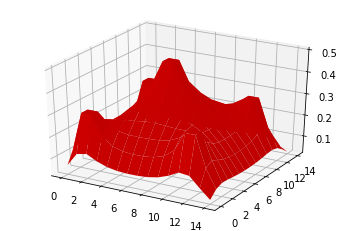

In [8]:
def circus(n=15):
    """Solve the circus tent problem for grid size length 'n'.
    Display the resulting figure.
    """
    H = laplacian(n)

    # Create the tent pole configuration.
    L = np.zeros((n, n))
    L[n // 2 - 1:n // 2 + 1, n // 2 - 1:n // 2 + 1] = .5
    m = [n // 6 - 1, n // 6, int(5 * (n / 6.)) - 1, int(5 * (n / 6.))]
    mask1, mask2 = np.meshgrid(m, m)
    L[mask1, mask2] = .3
    L = L.ravel()
    # Set initial guesses.
    x = np.ones((n, n)).ravel()
    y = np.ones(n ** 2)
    mu = np.ones(n ** 2)

    c = np.array([-1 * ((n - 1) ** -2) for i in range(n**2)])

    A = np.eye(225,225)

    z = qInteriorPoint(H, c, A, L, (x, y, mu))[0].reshape((n,n))

    # return L

    # Plot the solution.
    domain = np.arange(n)
    X, Y = np.meshgrid(domain, domain)
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_surface(X, Y, z, rstride=1, cstride=1, color='r')
    plt.show()
circus()


Suppose that we are given the following menu. here the use may supply a set of constraints in their nuturition. By default, we set the following constraints:

no more than 2000 calories
no more than  grams of fat
no more than  grams of sugar
at least 1000 miligrams of calcium
at least 25 grams of fiber
at least 46 grams of protein

The algorithm is able to determine what the cheapest possible menu is given these constraints

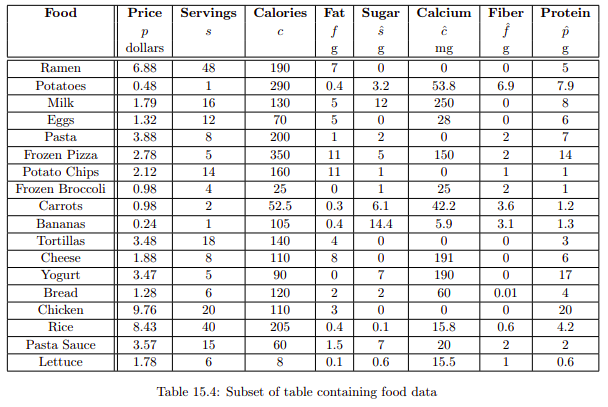

In [25]:
def optimize_menu():
    """Solve the college student food problem. Read the data in the file 
    food.npy to create a convex optimization problem. The first column is 
    the price, second is the number of servings, and the rest contain
    nutritional information. Use cvxpy to find the minimizer and primal 
    objective.
    
    Returns (in order):
        The optimizer x (ndarray)
        The optimal value (float)
    """
    # set up constraints and objective functions
    foodTable = np.load("food.npy", allow_pickle=True)
    trueNutritionalValues = np.multiply(foodTable[:,1], foodTable[:,2:].T).T
    c = foodTable[:, 0]
    x = cp.Variable(len(c), nonneg=True)
    objective = cp.Minimize(c.T @ x)

    # trueNutritionalValues variables are in this order:
    # 1. calories, 2. grams of fat, 3. 50 grams sugar, 4. 1000 mg calcium
    # 5. grams fiber, 6. protein
    # calcualte constraints as given in table
    constraints = [ trueNutritionalValues[:,0]@x <= 2000, 
                   trueNutritionalValues[:,1]@x <= 65, 
                   trueNutritionalValues[:,2]@x <= 50, 
                   trueNutritionalValues[:,3]@x >= 1000, 
                   trueNutritionalValues[:,4]@x >= 25,  
                   trueNutritionalValues[:,5]@x >= 46 ]

    # calculate results
    problem = cp.Problem(objective, constraints)
    solutionVal = problem.solve()
    solutionPoint = x.value

    #display most important foods by given name
    foodNames = np.array(["ramen", "potatos", "milk", "eggs", "pasta", 
                          "frozen pizza", "potato chips", "frozen broccoli", 
                          "carrots", "bananas", "tortillas", "cheese", 
                          "yogurt", "bread", "chicken", "rice", "pasta sauce", 
                          "lettuc"])
    print(f'The most consumed foods are: {foodNames[np.argsort(solutionPoint*-1)]}')
    print()
    print("Cheapest Menu:")
    for i in range(len(foodNames)):
      print(f' {solutionPoint[i]} servings of {foodNames[i]}')
    print()
    print(f'Total cost: {solutionVal}')

    return solutionPoint, solutionVal

solutionPoint, solutionVal = optimize_menu()

The most consumed foods are: ['potatos' 'milk' 'cheese' 'frozen broccoli' 'bananas' 'potato chips'
 'carrots' 'bread' 'frozen pizza' 'lettuc' 'eggs' 'yogurt' 'ramen' 'pasta'
 'tortillas' 'rice' 'pasta sauce' 'chicken']

Cheapest Menu:
 9.123363746788577e-13 servings of ramen
 3.6231884057437536 servings of potatos
 0.20003019323338328 servings of milk
 1.5708480430851334e-12 servings of eggs
 6.678716777187951e-13 servings of pasta
 2.1244482036613995e-12 servings of frozen pizza
 1.179374672197234e-11 servings of potato chips
 1.3661144925666706e-11 servings of frozen broccoli
 4.741349174668886e-12 servings of carrots
 1.2808616172852467e-11 servings of bananas
 5.993285680897992e-13 servings of tortillas
 0.0032406353620501567 servings of cheese
 9.96236095283923e-13 servings of yogurt
 3.3793415504600543e-12 servings of bread
 0.0 servings of chicken
 5.620440635464812e-13 servings of rice
 4.4376287005174056e-13 servings of pasta sauce
 1.6231064698316206e-12 servings of lettuc

T

Obviously everyone wants to marry the perfect person for them. However, everyone also knows that at some point we got to just take what we can get. This function helps determine where that optimal point is. For the function, we enter the number of people we are likely to date. The program then generates a number where if we have any date that is better than all previous dates we should marry that person.

In [29]:
import numpy as np

import matplotlib.pyplot as plt

def calc_stopping(N):
    """Calculate the optimal stopping time and expected value for the
    marriage problem.

    Parameters:
        N (int): The number of candidates.

    Returns:
        (float): The maximum expected value of choosing the best candidate.
        (int): The index of the maximum expected value.
    """
    expectedValues = [0]
    # loop through all needed n values
    for i in range(N-1):
        t = N - i
        expectedValues.append( max( (t-1)/t * expectedValues[-1] + (1/N), expectedValues[-1] ) )
    # get and return best value
    argMax = np.argmax(expectedValues)
    return expectedValues[argMax], N - argMax




Given that we follow the scheme from the previous function, we can estimate the expected value of our marriage outcome given how many dates we are willing to go on. For each number of maximum dates, this graphs produces the following

Expected Marriage Value: how good you expect your marriage to be given how many dates you ahve been on

Optimal stopping percentage: what percentage of dates should you reject before accepting the next best one


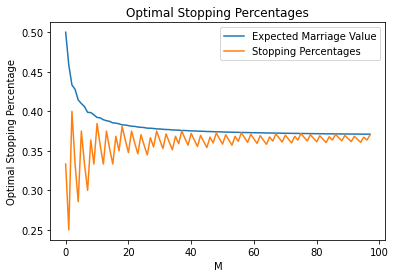

0.37

In [30]:
def graph_stopping_times(M):
    """Graph the optimal stopping percentage of candidates to interview and
    the maximum probability against M.

    Parameters:
        M (int): The maximum number of candidates.

    Returns:
        (float): The optimal stopping percent of candidates for M.
    """

    # get needed percentages for all m
    stoppingPercentages = []
    stoppingIndex = []
    for n in range(3, M+1):
        stoppingResult = calc_stopping(n)
        stoppingIndex.append(stoppingResult[0])
        stoppingPercentages.append(stoppingResult[1]/n)

    # plot results
    plt.plot(stoppingIndex, label="Expected Marriage Value")
    plt.plot(stoppingPercentages, label="Stopping Percentages")
    plt.xlabel("M")
    plt.ylabel("Optimal Stopping Percentage")
    plt.title("Optimal Stopping Percentages")
    plt.legend()
    plt.show()

    return stoppingPercentages[-1]

graph_stopping_times(100)

Eating Cake:
Eating cake is widely considsed a light pleasantry to be enjoyed casually. For this problem, we attempt to take out all the fun in eating cake and instead introduce cold optimization to forcibly maximize enjoyment. For this, we assume that the worth of eating cake decays following a square root function (becasue new cake is tastier than old cake) and we assume that the utility of each bit decreases in each serving. 

[0.4, 0.2, 0.2, 0.2, 0.0]


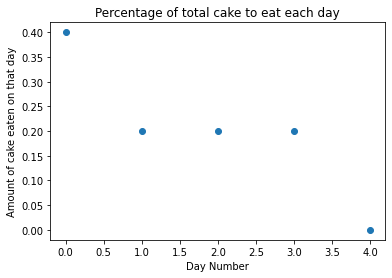

In [38]:
def get_consumption(N, u=lambda x: np.sqrt(x)):
    """Create the consumption matrix for the given parameters.

    Parameters:
        N (int): Number of pieces given, where each piece of cake is the
            same size.
        u (function): Utility function.

    Returns:
        C ((N+1,N+1) ndarray): The consumption matrix.
    """
    # fill evenly spaced w array
    w = np.arange(N+1) / N

    # calculate consumption matrix as described in PDF
    C = np.array([[ u(w[i] - w[j]) if w[i] - w[j] > 0 else 0 for i in range(N+1) ] for j in range(N+1)]).T

    return C


# Problems 4-6
def eat_cake(T, N, B, u=lambda x: np.sqrt(x)):
    """Create the value and policy matrices for the given parameters.

    Parameters:
        T (int): Time at which to end (T+1 intervals).
        N (int): Number of pieces given, where each piece of cake is the
            same size.
        B (float): Discount factor, where 0 < B < 1.
        u (function): Utility function.

    Returns:
        A ((N+1,T+1) ndarray): The matrix where the (ij)th entry is the
            value of having w_i cake at time j.
        P ((N+1,T+1) ndarray): The matrix where the (ij)th entry is the
            number of pieces to consume given i pieces at time j.
    """
    # get consumption matrix
    conumptionMatrix = get_consumption(N, u=u)

    w = np.arange(N + 1) / N

    A = np.zeros((N + 1, T+1))

    A[:, -1] = u(w)

    # fill in empty policy matrix
    P = np.zeros((N + 1, N))

    # add in last row (this is the final step in which we always eat all left over cake)
    P[:, -1] = w

    # we use this mask to zero out the entries that are always zero making this a lower triangular matrix
    mask = np.tril(np.ones((N + 1, N + 1)))

    # current value matrix
    CV = conumptionMatrix

    for i in range(T):
        t = T - i #convert i to the time step we are processing
        nextTimeStepValues = A[:, t] * B #the values at the next time step times beta
        addingCover = np.array([nextTimeStepValues for i in range(N + 1)]) #matrix to add to consumption matrix to make current values
        CV = np.multiply(conumptionMatrix + addingCover, mask) #update current value matrix
        A[:, t - 1] = np.max(CV, axis=1) #values for time step saved
        P[:, -2 - i] = w - w[np.argmax(CV, axis=1)] #policy matrix updated

    return A, P

# Problem 7
def find_policy(T, N, B, u=np.sqrt):
    """Find the most optimal cake eating policy assuming that we start with all of
    the pieces. Show a graph of the optimal policy using graph_policy().

    Parameters:
        T (int): Time at which to end (T+1 intervals).
        N (int): Number of pieces given, where each piece of cake is the
            same size.
        B (float): Discount factor, where 0 < B < 1.
        u (function): Utility function.

    Returns:
        ((T,) ndarray): The matrix describing the optimal percentage to
            consume at each time.
    """
    # get current value and policy from eat_cake function
    CV, P = eat_cake(T, N, B, u=u)

    # step parameters
    w = np.arange(N + 1) / N
    stepLength = w[1] - w[0]

    # first step in policy will always be P[-1, N-T-1] as this coordinates with the first time step and the entire cake is still dispensible
    policy = [P[-1,(N-T-1)]]

    total = 0

    # generate policy
    for i in range(N-T,N):
      total += int(policy[-1] / stepLength)
      policy.append(round(P[N - total,i], 5))

    plt.title("Percentage of total cake to eat each day")

    plt.xlabel("Day Number")

    plt.ylabel("Amount of cake eaten on that day")

    plt.scatter(np.arange(len(policy)), policy)

    return policy

find_policy(4, 5, .9, u=lambda x: 3 - 3/(1+x) )